In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

In [3]:
import utils as U

In [4]:
DATASETS_DIR = Path(os.environ.get('DATASETS_DIR', '.'))
DATASETS_DIR

PosixPath('/datasets')

In [5]:
U.list_contents(DATASETS_DIR/'DHCD')

Files: (0) | Folders: (2)

In [6]:
U.list_contents(DATASETS_DIR/'DHCD').folders

[PosixPath('/datasets/DHCD/Train'), PosixPath('/datasets/DHCD/Test')]

In [7]:
U.list_contents(DATASETS_DIR/'DHCD'/'Train')

Files: (0) | Folders: (46)

In [8]:
U.list_contents(DATASETS_DIR/'DHCD'/'Test')

Files: (0) | Folders: (46)

In [9]:
U.list_contents(DATASETS_DIR/'DHCD'/'Train').folders[:5]

[PosixPath('/datasets/DHCD/Train/character_29_waw'),
 PosixPath('/datasets/DHCD/Train/character_19_dha'),
 PosixPath('/datasets/DHCD/Train/character_2_kha'),
 PosixPath('/datasets/DHCD/Train/character_14_dhaa'),
 PosixPath('/datasets/DHCD/Train/digit_8')]

In [10]:
U.list_contents(DATASETS_DIR/'DHCD'/'Test').folders[:5]

[PosixPath('/datasets/DHCD/Test/character_29_waw'),
 PosixPath('/datasets/DHCD/Test/character_19_dha'),
 PosixPath('/datasets/DHCD/Test/character_2_kha'),
 PosixPath('/datasets/DHCD/Test/character_14_dhaa'),
 PosixPath('/datasets/DHCD/Test/digit_8')]

In [11]:
import numpy as np
import torch
import random

In [12]:
RANDOM_SEED = 817

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [13]:
torch.cuda.is_available(), torch.cuda.device_count()

(True, 1)

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(DEVICE)
DEVICE

device(type='cuda')

In [15]:
from torch.utils.data import Dataset

from PIL import Image

In [16]:
class DHCDDataset(Dataset):
    
    LABELS = [ 
        'digit_0',                   'digit_1',                'digit_2',             'digit_3',               'digit_4',
        'digit_5',                   'digit_6',                'digit_7',             'digit_8',               'digit_9',
        'character_1_ka',            'character_2_kha',        'character_3_ga',      'character_4_gha',       'character_5_kna',
        'character_6_cha',           'character_7_chha',       'character_8_ja',      'character_9_jha',       'character_10_yna',
        'character_11_taamatar',     'character_12_thaa',      'character_13_daa',    'character_14_dhaa',     'character_15_adna',
        'character_16_tabala',       'character_17_tha',       'character_18_da',     'character_19_dha',      'character_20_na',
        'character_21_pa',           'character_22_pha',       'character_23_ba',     'character_24_bha',      'character_25_ma',
        'character_26_yaw',          'character_27_ra',        'character_28_la',     'character_29_waw',      'character_30_motosaw',
        'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha',     'character_34_chhya',    'character_35_tra',
        'character_36_gya'
    ]
    LABELS_TO_IDX = {label: i for i, label in enumerate(LABELS)}

    LABELS_DV = [ 
        '०', '१', '२', '३', '४', 
        '५', '६', '७', '८', '९',
        'क', 'ख', 'ग', 'घ', 'ङ',
        'च', 'छ', 'ज', 'झ', 'ञ',
        'ट', 'ठ', 'ड', 'ढ', 'ण',
        'त', 'थ', 'द', 'ध', 'न',
        'प', 'फ', 'ब', 'भ', 'म',
        'य', 'र', 'ल', 'व', 'श',
        'ष', 'स', 'ह', 'क्ष', 'त्र',
        'ज्ञ'
    ]

    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = self.__load_data()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label= self.data[idx]
        target = self.label_to_idx(label)
        img = Image.open(img_path)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
    
    def __load_data(self):
        return [(p.as_posix(), p.parent.name) 
                for p in self.img_dir.rglob('*.png')]

    def label_to_idx(self, label):
        return self.LABELS_TO_IDX[label]
    
    def idx_to_label(self, idx):
        return self.idx_to_labels(idx)["label"]

    def idx_to_labels(self, idx):
        return {
            "label": self.LABELS[idx],
            "label_dv": self.LABELS_DV[idx],
        }

In [17]:
from torchvision import transforms

In [18]:
train_data_path = DATASETS_DIR/'DHCD'/'Train'
valid_data_path = DATASETS_DIR/'DHCD'/'Test'

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

target_transform = transforms.Compose(
    [transforms.Lambda(lambda y: torch.zeros(46, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))]
)

train_ds = DHCDDataset(img_dir=train_data_path, transform=transform, target_transform=target_transform)
valid_ds = DHCDDataset(img_dir=valid_data_path, transform=transform, target_transform=target_transform)

In [20]:
x, y = train_ds[45]
x.shape, y.shape

(torch.Size([1, 32, 32]), torch.Size([46]))

In [21]:
import matplotlib.pyplot as plt

In [22]:
def rand_show_dataset(dataset, rows=3, cols=7, size=3):
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i in range(1, rows * cols + 1):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img_t, target = dataset[idx]
        label_idx = torch.argmax(target)
        label = dataset.idx_to_label(label_idx)
        fig.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img_t.squeeze(), cmap="gray")

    plt.show()

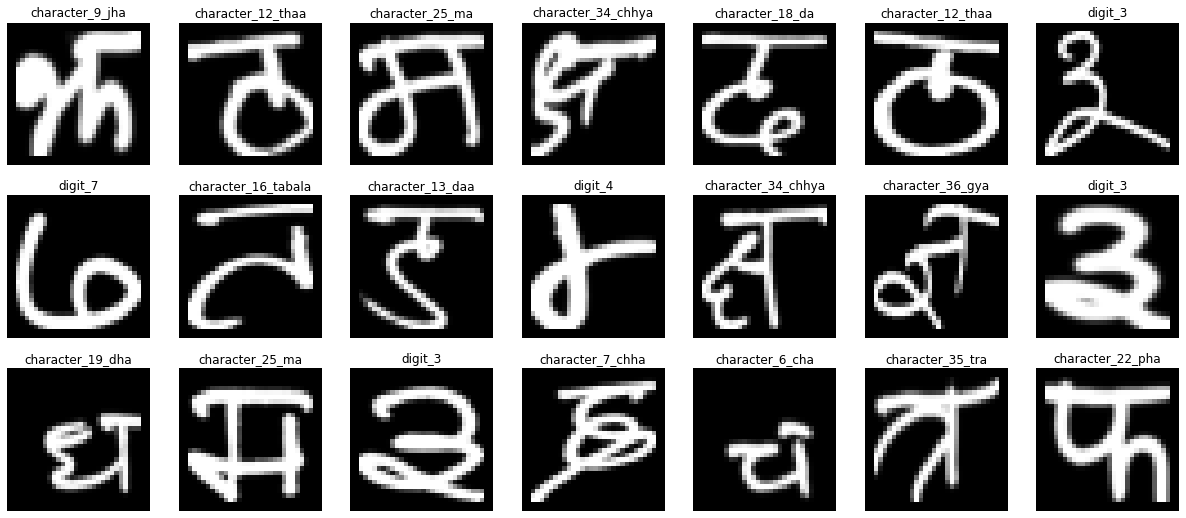

In [23]:
rand_show_dataset(train_ds)

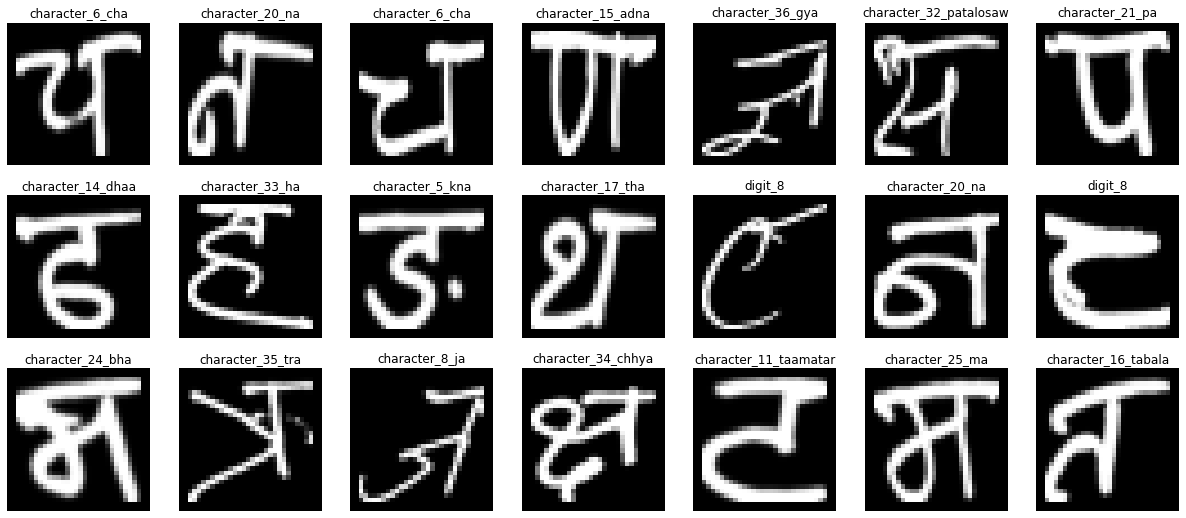

In [24]:
rand_show_dataset(valid_ds)

In [25]:
from torch.utils.data import DataLoader

In [26]:
dl_kwargs = {
    'batch_size': 3910,
    'shuffle': True
}

train_dl = DataLoader(train_ds, **dl_kwargs)
valid_dl = DataLoader(valid_ds, **dl_kwargs)

In [27]:
def show_first_batch_info(dl):
    imgs, targets = next(iter(dl))
    print(f"Images batch shape: {imgs.size()}")
    print(f"Labels batch shape: {targets.size()}")

    print("First image & label in the batch")
    img = imgs[0].squeeze()
    label_idx = torch.argmax(targets[0])
    labels = dl.dataset.idx_to_labels(label_idx)
    plt.imshow(img, cmap="gray")
    plt.title(f'Label : {labels["label"]}')
    plt.axis("off")
    plt.show()
    print(f"{labels['label_dv']} | {labels['label']}")

Images batch shape: torch.Size([3910, 1, 32, 32])
Labels batch shape: torch.Size([3910, 46])
First image & label in the batch


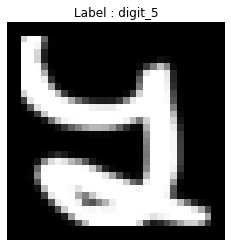

५ | digit_5


In [28]:
show_first_batch_info(train_dl)

Images batch shape: torch.Size([3910, 1, 32, 32])
Labels batch shape: torch.Size([3910, 46])
First image & label in the batch


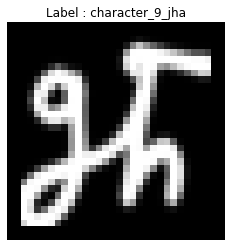

झ | character_9_jha


In [29]:
show_first_batch_info(valid_dl)

In [30]:
import torch.nn as nn
import torch.nn.functional as F

In [31]:
class DHCDNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # 32x32 -> 1024
        self.l1 = nn.Linear(32 * 32, 512)
        self.l2 = nn.Linear(512, 92)
        self.l3 = nn.Linear(92, 46)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        logits = self.l3(x)
        
        return logits

In [32]:
for name, param in DHCDNet().named_parameters():
    print(f"Layer: {name}  \t Size: {param.size()}")

Layer: l1.weight  	 Size: torch.Size([512, 1024])
Layer: l1.bias  	 Size: torch.Size([512])
Layer: l2.weight  	 Size: torch.Size([92, 512])
Layer: l2.bias  	 Size: torch.Size([92])
Layer: l3.weight  	 Size: torch.Size([46, 92])
Layer: l3.bias  	 Size: torch.Size([46])


In [ ]:
data, target = next(iter(train_dl))

In [ ]:
data.shape

torch.Size([3910, 1, 32, 32])

In [ ]:
target.shape

torch.Size([3910, 46])

In [46]:
data.view(3910, -1).shape

torch.Size([3910, 1024])

In [ ]:
target[0, :]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
# Data ready, Model ready

In [34]:
# Init --> predict, loss, backward, step, zero_grad --> stop

In [35]:
def train(model, device, dl, optimizer, loss_fn, epoch, log_interval=9):
    model.train()
    for batch_idx, (data, target) in enumerate(dl):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dl.dataset),
                100. * batch_idx / len(train_dl), loss.item()))

In [36]:
def valid(model, device, dl, loss_fn):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            # sum up batch loss
            valid_loss += loss_fn(output, target, reduction='sum').item()            
            correct += probs.argmax(dim=1).eq(target.argmax(dim=1)).sum().item()

    valid_loss /= len(dl.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(dl.dataset),
        100. * correct / len(dl.dataset)))

In [37]:
def decay_lr(scheduler):
    scheduler.step()
    print(f'Updated LR : {scheduler.get_last_lr()}')

In [38]:
import torch.optim as optim
# from torch.optim.lr_scheduler import ExponentialLR

In [39]:
# learning_rate = 5e-1
# learning_rate_decay = 1e-1

model = DHCDNet().to(DEVICE)
loss_fn = F.cross_entropy
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = ExponentialLR(optimizer, gamma=learning_rate_decay)

In [40]:
for epoch in range(0, 30):
    optimizer = optim.SGD(model.parameters(), lr=5e-1)
    train(model, DEVICE, train_dl, optimizer, loss_fn, epoch)
    valid(model, DEVICE, valid_dl, loss_fn)
    # decay_lr(scheduler)
    print("=======")

Train Epoch: 0 [0/78200 (0%)]	Loss: 3.829508
Train Epoch: 0 [35190/78200 (45%)]	Loss: 3.747719
Train Epoch: 0 [70380/78200 (90%)]	Loss: 3.476291
Test set: Average loss: 3.3524, Accuracy: 3928/13800 (28%)
Train Epoch: 1 [0/78200 (0%)]	Loss: 3.362113
Train Epoch: 1 [35190/78200 (45%)]	Loss: 3.120848
Train Epoch: 1 [70380/78200 (90%)]	Loss: 2.600868
Test set: Average loss: 3.0791, Accuracy: 2536/13800 (18%)
Train Epoch: 2 [0/78200 (0%)]	Loss: 3.101132
Train Epoch: 2 [35190/78200 (45%)]	Loss: 2.811402
Train Epoch: 2 [70380/78200 (90%)]	Loss: 2.472869
Test set: Average loss: 2.4498, Accuracy: 4958/13800 (36%)
Train Epoch: 3 [0/78200 (0%)]	Loss: 2.479800
Train Epoch: 3 [35190/78200 (45%)]	Loss: 1.894793
Train Epoch: 3 [70380/78200 (90%)]	Loss: 1.623454
Test set: Average loss: 2.3467, Accuracy: 5604/13800 (41%)
Train Epoch: 4 [0/78200 (0%)]	Loss: 2.330720
Train Epoch: 4 [35190/78200 (45%)]	Loss: 1.678850
Train Epoch: 4 [70380/78200 (90%)]	Loss: 1.418671
Test set: Average loss: 1.5915, Accurac

In [40]:
for epoch in range(0, 30):
    optimizer = optim.SGD(model.parameters(), lr=5e-1)
    train(model, DEVICE, train_dl, optimizer, loss_fn, epoch)
    valid(model, DEVICE, valid_dl, loss_fn)
    # decay_lr(scheduler)
    print("=======")

Train Epoch: 0 [0/78200 (0%)]	Loss: 3.829508
Train Epoch: 0 [35190/78200 (45%)]	Loss: 3.747719
Train Epoch: 0 [70380/78200 (90%)]	Loss: 3.476291
Test set: Average loss: 3.3524, Accuracy: 3928/13800 (28%)
Train Epoch: 1 [0/78200 (0%)]	Loss: 3.362113
Train Epoch: 1 [35190/78200 (45%)]	Loss: 3.120848
Train Epoch: 1 [70380/78200 (90%)]	Loss: 2.600868
Test set: Average loss: 3.0791, Accuracy: 2536/13800 (18%)
Train Epoch: 2 [0/78200 (0%)]	Loss: 3.101132
Train Epoch: 2 [35190/78200 (45%)]	Loss: 2.811402
Train Epoch: 2 [70380/78200 (90%)]	Loss: 2.472869
Test set: Average loss: 2.4498, Accuracy: 4958/13800 (36%)
Train Epoch: 3 [0/78200 (0%)]	Loss: 2.479800
Train Epoch: 3 [35190/78200 (45%)]	Loss: 1.894793
Train Epoch: 3 [70380/78200 (90%)]	Loss: 1.623454
Test set: Average loss: 2.3467, Accuracy: 5604/13800 (41%)
Train Epoch: 4 [0/78200 (0%)]	Loss: 2.330720
Train Epoch: 4 [35190/78200 (45%)]	Loss: 1.678850
Train Epoch: 4 [70380/78200 (90%)]	Loss: 1.418671
Test set: Average loss: 1.5915, Accurac